In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Twitter_Data.csv')

In [3]:
df = df[df.category != 0.0]
df = df.dropna()
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107758 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  107758 non-null  object 
 1   category    107758 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


I have no gpu , so i fine tuned the model on 20 documents

In [4]:
df = df.iloc[0:20]

In [5]:
decode_map = {-1.0: 0, 1.0: 1}
def decode_sentiment(label):
    return decode_map[(label)]

In [6]:
df.category = df.category.apply(lambda x: decode_sentiment(x))

In [7]:
df.category.unique()

array([0, 1], dtype=int64)

<function matplotlib.pyplot.show(close=None, block=None)>

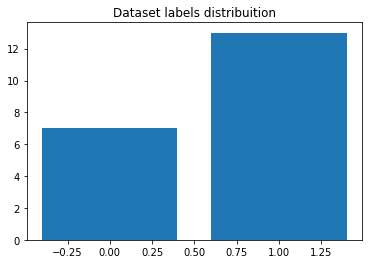

In [8]:
import matplotlib.pyplot as plt
cs = df.groupby('category')['clean_text'].count()
label = list(cs.keys())
values = list(cs.values)

# plt.figure(figsize=(8,8))
plt.bar(label, values)
plt.title("Dataset labels distribuition")
plt.show

In [9]:
cs

category
0     7
1    13
Name: clean_text, dtype: int64

In [10]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
8,with upcoming election india saga going import...,1


In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.20, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 16
TEST size: 4


In [12]:
X_train,y_train = list(df_train['clean_text']),list(df_train['category'])
X_test,y_test = list(df_test['clean_text']),list(df_test['category'])

In [13]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [14]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [15]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))
     

In [16]:
# import os
# os.mkdir('results')
# os.mkdir('logs')

In [17]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [18]:
with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)

trainer.train()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [19]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.6969732046127319}

In [20]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[ 0.02187972, -0.0560433 ],
       [ 0.01748109, -0.04182301],
       [ 0.01718114, -0.05685798],
       [ 0.02950619, -0.08662353]], dtype=float32), label_ids=array([0, 1, 0, 1]), metrics={'eval_loss': 0.6969732046127319})

In [21]:
trainer.predict(test_dataset)[1].shape

(4,)

In [22]:
output=trainer.predict(test_dataset)[1]

In [23]:
output

array([0, 1, 0, 1])

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
cm=confusion_matrix(y_test,output)
cm
   

array([[2, 0],
       [0, 2]], dtype=int64)

In [26]:
trainer.save_model('senti_model')